## Summary
This notebook addresses two main questions of interest - 
1. The important factors that determine the prices of Airbnb listings in Seattle 
2. What makes an Airbnb host a superhost

The first part of the notebook is EDA of the seattle listings data. Through the exploration of relationship between various variables in the dataset, I decided to do further analysis on the two points of interest above.

The second part is the in-depth analysis to uncover the key factors that influence the listing price. 
* First I built Lasso linear regression model with the original price values as the target, but the performance was unsatisfying. 
* Second try I applied a log transformation on the price because of its long tail shape in distribution, and fit the Lasso model again. This time the R-squared of the test set increased by 7% with the same set of independent variables.
* Finally a Random Forest model is trained with the same set of independent variables and log transformed price as target variable. The top differentiator from RF model is whether the room type is entire apartment while the top coefficients from the linear regression model are mostly about neighborhood. 

The third part explored the key factors that make an Airbnb host a superhost through a Random Forest classification model. The top features revealed include overall review ratings, host tenures, number of reviews. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [2]:
seattle_listing = pd.read_csv('data/seattle listings.csv')
seattle_reviews = pd.read_csv('data/seattle reviews.csv')
seattle_calendar = pd.read_csv('data/seattle calendar.csv')

In [3]:
seattle_listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [4]:
seattle_listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [5]:
seattle_listing[['review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value']].head()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,95.0,10.0,10.0,10.0,10.0,9.0,10.0
1,96.0,10.0,10.0,10.0,10.0,10.0,10.0
2,97.0,10.0,10.0,10.0,10.0,10.0,10.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92.0,9.0,9.0,10.0,10.0,9.0,9.0


In [6]:
seattle_listing[['host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
        'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed',
        'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'weekly_price', 'monthly_price']].head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price
0,within a few hours,96%,100%,f,Queen Anne,West Queen Anne,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN
1,within an hour,98%,100%,t,Queen Anne,West Queen Anne,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00"
2,within a few hours,67%,100%,f,Queen Anne,West Queen Anne,Queen Anne,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$975.00,NaN,NaN
3,NaN,NaN,NaN,f,Queen Anne,West Queen Anne,Queen Anne,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",NaN,$100.00,$650.00,"$2,300.00"
4,within an hour,100%,NaN,f,Queen Anne,West Queen Anne,Queen Anne,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",NaN,$450.00,NaN,NaN


In [7]:
seattle_listing[[ 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365']].head()

,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365
0,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346
1,$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291
2,"$1,000.00",$300.00,10,$25.00,4,30,5 weeks ago,t,1,6,17,220
3,NaN,NaN,1,$0.00,1,1125,6 months ago,t,0,0,0,143
4,$700.00,$125.00,6,$15.00,1,1125,7 weeks ago,t,30,60,90,365


In [8]:
seattle_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [9]:
print('data range from {} to {}'.format(seattle_calendar.date.min(), seattle_calendar.date.max()))

data range from 2016-01-04 to 2017-01-02


In [10]:
seattle_calendar.listing_id.unique().shape[0]

3818

In [11]:
seattle_listing.id.unique().shape[0]

3818

In [12]:
seattle_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


## 1. Exploratory Analysis

#### 1.1 Do superhosts always have higher ratings than regular airbnb hosts?

In [13]:
# how many hosts are actually superhosts?
seattle_listing.host_is_superhost.value_counts()

f    3038
t     778
Name: host_is_superhost, dtype: int64

Text(0.5, 1.0, 'Non-Superhost Ratings Distribution')

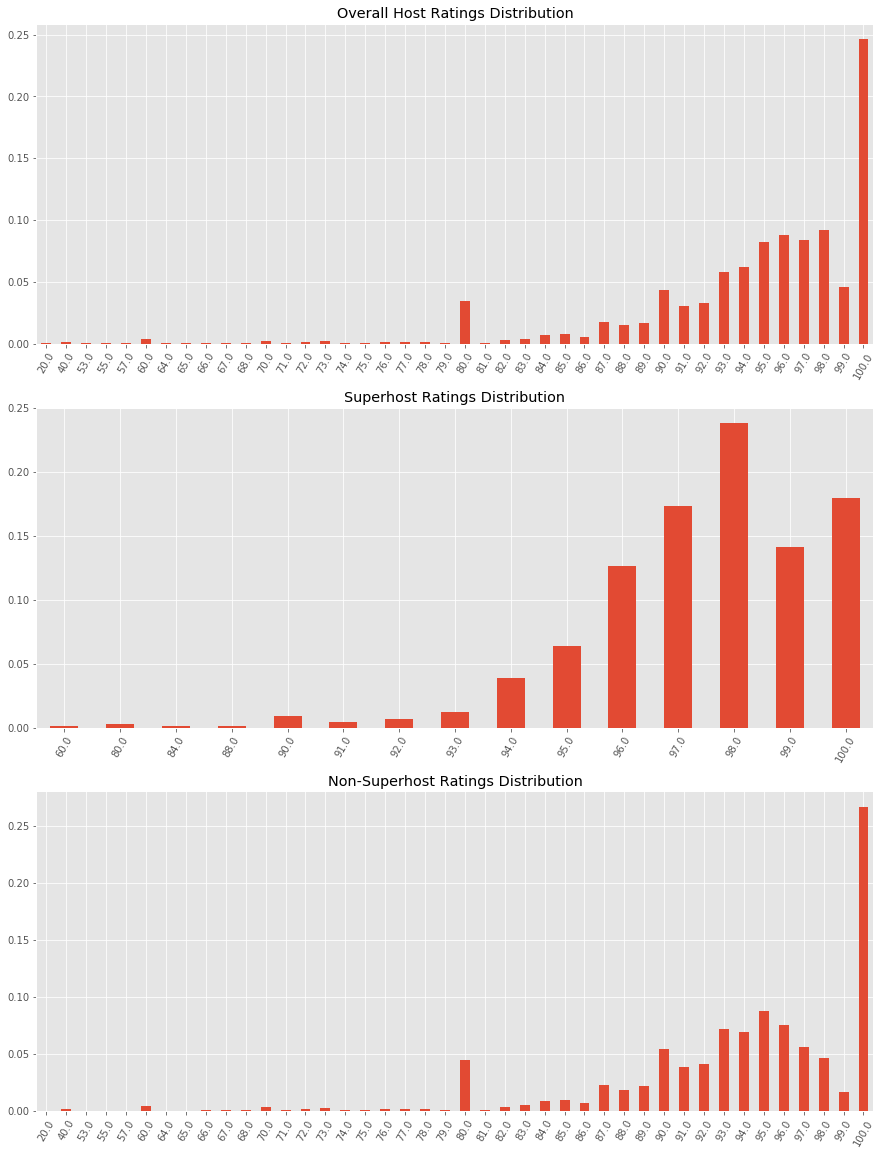

In [14]:
plt.figure(figsize=(15,20))
plt.subplot(3,1,1)
(seattle_listing.review_scores_rating.value_counts()/seattle_listing.review_scores_rating.count()).sort_index().plot.bar(rot=60)
plt.title('Overall Host Ratings Distribution')

plt.subplot(3,1,2)
(seattle_listing.loc[seattle_listing['host_is_superhost']=='t','review_scores_rating'].value_counts()/seattle_listing.loc[seattle_listing['host_is_superhost']=='t','review_scores_rating'].count()).sort_index().plot.bar(rot=60)
plt.title('Superhost Ratings Distribution')

plt.subplot(3,1,3)
(seattle_listing.loc[seattle_listing['host_is_superhost']=='f','review_scores_rating'].value_counts()/seattle_listing.loc[seattle_listing['host_is_superhost']=='f','review_scores_rating'].count()).sort_index().plot.bar(rot=60)
plt.title('Non-Superhost Ratings Distribution')

([<matplotlib.axis.XTick at 0x1a172f8630>,
 <a list of 2 Text xticklabel objects>)

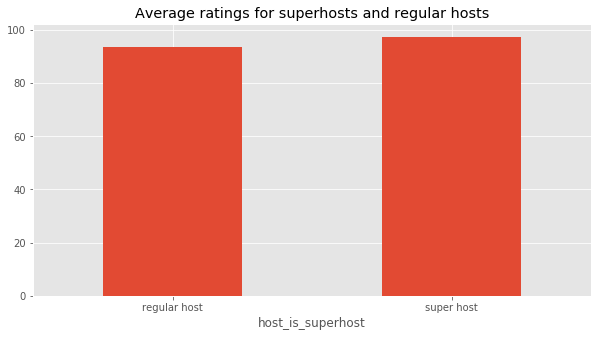

In [15]:
plt.figure(figsize=(10,5))
(seattle_listing.groupby('host_is_superhost')['review_scores_rating'].mean()).plot.bar(rot=0)
plt.title('Average ratings for superhosts and regular hosts')
plt.xticks(np.arange(2),('regular host','super host'))

* Interestingly, regular Airbnb hosts have higher percent of 100 scores than the super hosts, although the superhosts have slightly higher average ratings than non-superhosts. That means guests choosing a non-superhost can sometimes have a better experience than choosing a super host, although the latter is a guarantee that a guest would at least have a good experience since >90% the ratings of superhosts are above 90, compared to only 61% ratings above 90 for the regular hosts, due to the long tail in the lower ratings.

#### 1.2 Which neighborhood in Seattle is most popular and has the most listings?

Text(0, 0.5, '')

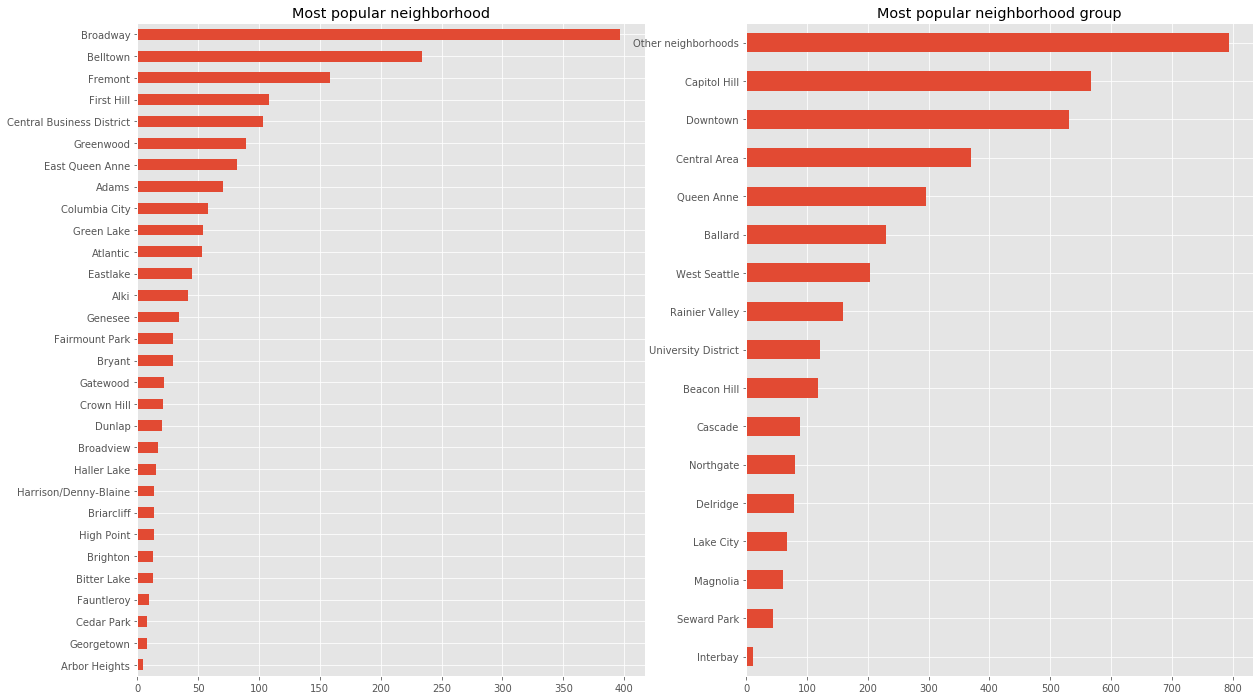

In [16]:
plt.figure(figsize=(20,12))
plt.subplot(1,2,1)
seattle_listing.groupby('neighbourhood_cleansed').id.count()[:30].sort_values().plot.barh()
plt.title('Most popular neighborhood')
plt.ylabel('')

plt.subplot(1,2,2)
seattle_listing.groupby('neighbourhood_group_cleansed').id.count().sort_values().plot.barh()
plt.title('Most popular neighborhood group')
plt.ylabel('')

* Broadway and Belltown neighborhood have the most host listings, which is expected since they are most close to the tourist attractions in Seattle. Downtown and Capitol Hill are among the top of popular neighborhood areas. 

#### 1.3 Which neighborhood is most expensive on average among all Airbnb listings in Seattle?

In [17]:
seattle_listing['price'] = seattle_listing['price'].str.replace('$','').str.replace(',','').astype('float64')

Text(0, 0.5, 'Average Nightly Price by Neighborhood')

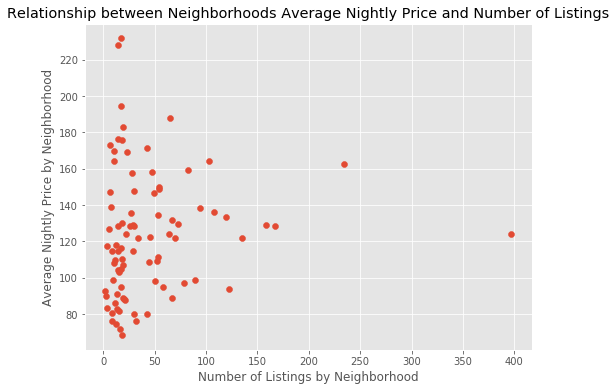

In [18]:
plt.figure(figsize=(8,6))
price = seattle_listing.groupby('neighbourhood_cleansed').price.mean()#[:50].sort_values().plot.barh()
num_listing = seattle_listing.groupby('neighbourhood_cleansed').id.count()
plt.scatter(num_listing, price)
plt.title('Relationship between Neighborhoods Average Nightly Price and Number of Listings')
plt.xlabel('Number of Listings by Neighborhood')
plt.ylabel('Average Nightly Price by Neighborhood')

In [19]:
# what are the 2 most expensive nighborhoods with avg nightly price >$200 on the scatter plot?
price[price>200]

neighbourhood_cleansed
Portage Bay           227.857143
Southeast Magnolia    231.705882
Name: price, dtype: float64

After exploring the dataset a little bit, I start to have some clear idea about the type of business questions I want to address with the data availabel through more in-depth analysis and modeling.

### Questions to address - 
##### 1) What are the key factors that contribute to the price of a listing? If given all the information of a airbnb listing, can we predict its nightly price with reasonable confidence?
##### 2)  What are the main factors that make a host superhost? 

## 2. Data Cleaning & Feature Engineering

In [20]:
seattle_listing.bed_type.value_counts()

Real Bed         3657
Futon              74
Pull-out Sofa      47
Airbed             27
Couch              13
Name: bed_type, dtype: int64

In [21]:
seattle_listing.isnull().sum()

id                                     0
listing_url                            0
scrape_id                              0
last_scraped                           0
name                                   0
summary                              177
space                                569
description                            0
experiences_offered                    0
neighborhood_overview               1032
notes                               1606
transit                              934
thumbnail_url                        320
medium_url                           320
picture_url                            0
xl_picture_url                       320
host_id                                0
host_url                               0
host_name                              2
host_since                             2
host_location                          8
host_about                           859
host_response_time                   523
host_response_rate                   523
host_acceptance_

In [22]:
# remove some unrelated and correlated columns to the analyses of interest to keep only the necessary columns
keep_col = ['id', 
       'host_since',
       'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed','neighbourhood_group_cleansed', 
        'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type','square_feet',
       'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people',
       'availability_90',
       'number_of_reviews',
       'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy',  'calculated_host_listings_count',
       'reviews_per_month']

In [23]:
listing_clean = seattle_listing[keep_col]
listing_clean.head()

,id,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month
0,241032,2011-08-11,"I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,t,t,West Queen Anne,...,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,2,4.07
1,953595,2013-02-21,Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,t,t,West Queen Anne,...,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,6,1.48
2,3308979,2014-06-12,i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,t,t,West Queen Anne,...,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,2,1.15
3,7421966,2013-11-06,NaN,NaN,NaN,NaN,f,t,t,West Queen Anne,...,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,1,NaN
4,278830,2011-11-29,"Hi, I live in Seattle, Washington but I'm orig...",within an hour,100%,NaN,f,t,t,West Queen Anne,...,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,1,0.89


In [24]:
#convert numerical columns to float from string
for col in ['host_response_rate', 'host_acceptance_rate','security_deposit','cleaning_fee','extra_people']:
    listing_clean[col] = listing_clean[col].str.replace('$','').str.replace('%','').str.replace(',','').astype('float64')

In [25]:
listing_clean[['host_response_rate', 'host_acceptance_rate','security_deposit','cleaning_fee']].head()

,host_response_rate,host_acceptance_rate,security_deposit,cleaning_fee
0,96.0,100.0,NaN,NaN
1,98.0,100.0,100.0,40.0
2,67.0,100.0,1000.0,300.0
3,NaN,NaN,NaN,NaN
4,100.0,NaN,700.0,125.0


In [26]:
listing_clean.drop('square_feet',axis=1, inplace=True) # too many na values, drop

##### engineer 2 features about the host

1. create "tenure" feature of the host based on "host_since". 

In [27]:
# there can be new hosts who just joined between 2016-01-04 and 2017-01-02, 
#so I use the last date in calendar to calculate tenure (number of months since becoming hosts)
listing_clean['host_tenure'] = (pd.to_datetime(seattle_calendar.date.max())- pd.to_datetime(listing_clean['host_since'])) // np.timedelta64(1, 'M')

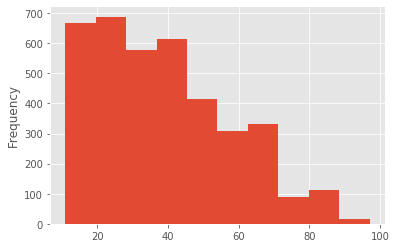

In [28]:
listing_clean['host_tenure'].plot.hist()

In [29]:
print('hosts tenure ranges from {} months to {} months'.format(listing_clean['host_tenure'].min(), listing_clean['host_tenure'].max()))

hosts tenure ranges from 11.0 months to 97.0 months


2. whether host wrote "about me" section on airbnb - if ‘host_about’ is not null then 1 else 0 

In [30]:
listing_clean['host_intro'] = np.where(listing_clean['host_about'].isnull(), 0, 1)

In [31]:
listing_clean[['host_intro','host_about']].head()

,host_intro,host_about
0,1,"I am an artist, interior designer, and run a s..."
1,1,Living east coast/left coast/overseas. Time i...
2,1,i love living in Seattle. i grew up in the mi...
3,0,NaN
4,1,"Hi, I live in Seattle, Washington but I'm orig..."


In [32]:
listing_clean.drop(['host_about','host_since'],axis=1, inplace=True)

###### impute non-numerical missing values

In [33]:
na_col = listing_clean.isnull().sum()[listing_clean.isnull().sum()>0].index
na_col
# columns need to impute

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'property_type', 'bathrooms', 'bedrooms', 'beds', 'security_deposit',
       'cleaning_fee', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'host_tenure'],
      dtype='object')

In [34]:
listing_clean[na_col].isnull().sum()

host_response_time              523
host_response_rate              523
host_acceptance_rate            773
host_is_superhost                 2
host_has_profile_pic              2
host_identity_verified            2
property_type                     1
bathrooms                        16
bedrooms                          6
beds                              1
security_deposit               1952
cleaning_fee                   1030
review_scores_rating            647
review_scores_accuracy          658
review_scores_cleanliness       653
review_scores_checkin           658
review_scores_communication     651
review_scores_location          655
review_scores_value             656
reviews_per_month               627
host_tenure                       2
dtype: int64

In [35]:
# continuous variables 
impute_0_col = ['security_deposit','cleaning_fee']
impute_median_col = ['host_tenure', 'host_response_time', 'host_response_rate','host_acceptance_rate','bathrooms', 'bedrooms', 'beds',
                    'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication',
                    'review_scores_location', 'review_scores_value', 'reviews_per_month']
# categorical variables, fill with the mode value
impute_mode_col = ['host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'property_type']

In [36]:
listing_clean[impute_0_col].fillna(0)
# impute the missing categorical values before one-hot encoding
for col in impute_mode_col:
    listing_clean[col].fillna(listing_clean[col].mode()[0], inplace=True)

##### one-hot encoding categorical variables

In [37]:
categorical_col = list(listing_clean.dtypes[listing_clean.dtypes=='object'].index)

In [38]:
categorical_col

['host_response_time',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'instant_bookable',
 'cancellation_policy']

In [39]:
tf_col = ['host_is_superhost','host_has_profile_pic', 'host_identity_verified','instant_bookable']
for col in tf_col:
    listing_clean[col] = np.where(listing_clean[col]=='t',1,0)
    
listing_clean_dummy = pd.get_dummies(listing_clean.drop('id',axis=1), columns= [i for i in categorical_col if i not in tf_col ])

In [40]:
listing_clean_dummy.dtypes.value_counts()

uint8      135
float64     18
int64       10
dtype: int64

In [41]:
#listing_clean_dummy.columns
dummy_col = list(listing_clean_dummy.dtypes[listing_clean_dummy.dtypes=='uint8'].index) + tf_col
numerical_col = [i for i in listing_clean_dummy.columns if i not in dummy_col]

# this dataset still contains missing values in continous columns, will impute later after train-test split

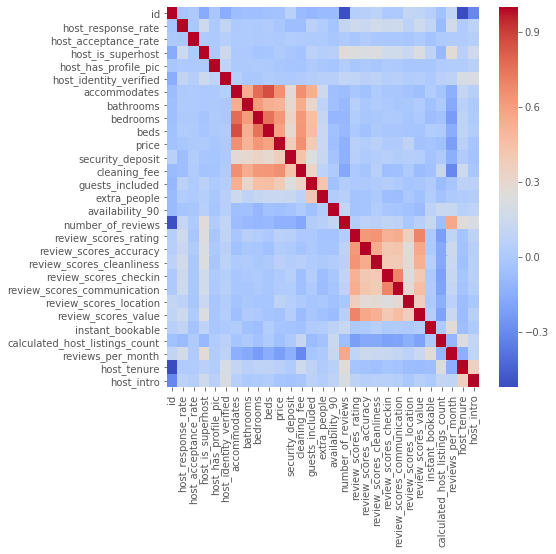

In [81]:
plt.figure(figsize = (7,7))
feature_corr = listing_clean.corr()
sns.heatmap(feature_corr, cmap = 'coolwarm')

* price seems to be most correlated with accommodates and bedrooms

## 3. Price Prediction

In [42]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(listing_clean_dummy.drop('price',axis=1), listing_clean_dummy['price'], test_size=0.2)

In [43]:
numerical_col_index = [list(x_train.columns).index(i) for i in numerical_col if i != 'price']
dummy_col_index = [list(x_train.columns).index(i) for i in dummy_col]

### 1. A simiple linear regression with regularization (Lasso)

In [44]:
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.linear_model import LassoCV, ElasticNet, RidgeCV

pipeline=Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'median')),
    ('feature_processing', FeatureUnion(transformer_list = [
            ('categorical', FunctionTransformer(lambda data: data[:,dummy_col_index])),

            #only impute and standardize numeric data
            ('numeric', Pipeline(steps = [
                ('select', FunctionTransformer(lambda data: data[:,numerical_col_index])),
                #('imputer',SimpleImputer(strategy = 'median')),
                ('scaler', StandardScaler())
                        ]))
        ])),
    ('model', LassoCV(cv=10))
    ]
)

In [45]:
pipeline.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x1a1b718730>,
                                                                     inv_kw_args=None,
                                                                     inverse_...
                                                                  StandardScaler(copy=True,
                                                            

In [46]:
print('training r2 score: {}'.format(pipeline.score(x_train, y_train)))
print('test r2 score: {}'.format(pipeline.score(x_test, y_test)))

training r2 score: 0.6319908539997627
test r2 score: 0.6118225458185194


In [49]:
# test how close the predicted prices are against true price
rand_id_1 = np.random.choice(y_test.index, 1)[0]
print('real price of listing id {} is {}, the predicted price is {}'.format(listing_clean.loc[rand_id_1].id, y_test.loc[rand_id_1], y_pred_lasso[np.argwhere(y_test.index== rand_id_1)[0][0]] ))

rand_id_2 = np.random.choice(y_test.index, 1)[0]
print('real price of listing id {} is {}, the predicted price is {}'.format(listing_clean.loc[rand_id_2].id, y_test.loc[rand_id_2], y_pred_lasso[np.argwhere(y_test.index== rand_id_2)[0][0]] ))

real price of listing id 2642359 is 49.0, the predicted price is 70.37663597850599
real price of listing id 3528627 is 70.0, the predicted price is 78.8809762300042


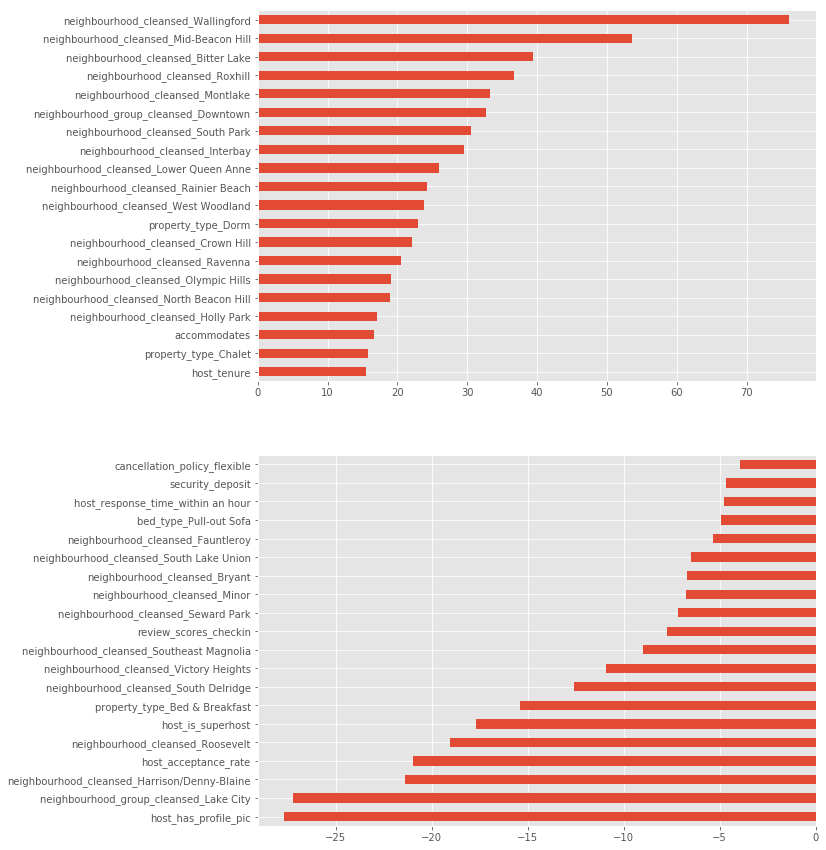

In [50]:
plt.figure(figsize=(10,15))
plt.subplot(2,1,2)
pd.Series(pipeline.named_steps['model'].coef_, index= x_train.columns).sort_values()[:20].plot.barh()

plt.subplot(2,1,1)
pd.Series(pipeline.named_steps['model'].coef_, index= x_train.columns).sort_values()[-20:].plot.barh()


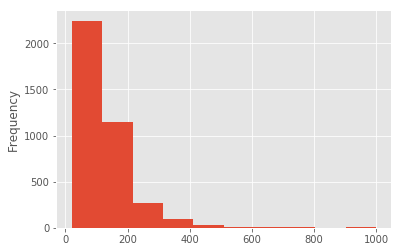

In [98]:
listing_clean.price.plot.hist()

##### Interpretation
* The coefficients from Lasso linear regression indicate that the neighborhood has the most impact on the price of the airbnb listing since they cover the most of the top and bottom coefficients. For example, If a listing is the Wallingford, the price can be about $80 higher with everything else constant. 

* Another very surprising finding is that the host_is_superhost and host_has_profile_pic actually are negatively correlated to the price. If a host is a superhost, the price will be about $16 lower on average comparing to the listing from a regular host holding everything else constant.

##### Thoughts
* Given the long tail shape of the price distribution, what will happen if I apply a log transformation on price and use the log price as target variable?

(array([  23.,  164.,  426., 1040., 1041.,  678.,  288.,  116.,   29.,
          13.]),
 array([2.99573227, 3.38693457, 3.77813687, 4.16933918, 4.56054148,
        4.95174378, 5.34294608, 5.73414838, 6.12535068, 6.51655298,
        6.90775528]),
 <a list of 10 Patch objects>)

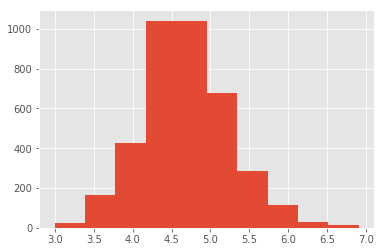

In [66]:
plt.hist(np.log(listing_clean_dummy.price))

### 2. Lasso regression with regularization using log(price) as dependent variable

In [99]:
pipeline2=Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'median')),
    ('feature_processing', FeatureUnion(transformer_list = [
            ('categorical', FunctionTransformer(lambda data: data[:,dummy_col_index])),

            #only impute and standardize numeric data
            ('numeric', Pipeline(steps = [
                ('select', FunctionTransformer(lambda data: data[:,numerical_col_index])),
                ('scaler', StandardScaler())
                        ]))
        ])),
    ('model', LassoCV(cv=10))
    ]
)

pipeline2.fit(x_train, np.log(y_train))

Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('feature_processing', FeatureUnion(n_jobs=None,
       transformer_list=[('categorical', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lam...ve=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False))])

In [103]:
print('training r2 score: {}'.format(pipeline2.score(x_train, np.log(y_train))))
y_pred_lasso2 = pipeline2.predict(x_test)
print('test r2 score: {}'.format(pipeline2.score(x_test, np.log(y_test))))

training r2 score: 0.7283786071470706
test r2 score: 0.6812116756585492


In [106]:
# test how close the predicted prices are against true price
# to conver the predicted price back to normal , just apply np.exp on the prediced price.
rand_id_1 = np.random.choice(y_test.index, 1)[0]
print('real price of listing id {} is {}, the predicted price is {}'.format(listing_clean.loc[rand_id_1].id, y_test.loc[rand_id_1], np.exp(y_pred_lasso2[np.argwhere(y_test.index== rand_id_1)[0][0]]) ))

rand_id_2 = np.random.choice(y_test.index, 1)[0]
print('real price of listing id {} is {}, the predicted price is {}'.format(listing_clean.loc[rand_id_2].id, y_test.loc[rand_id_2], np.exp(y_pred_lasso2[np.argwhere(y_test.index== rand_id_2)[0][0]]) ))

real price of listing id 8814802 is 100.0, the predicted price is 87.05753243816451
real price of listing id 3120652 is 124.0, the predicted price is 127.80729749127337


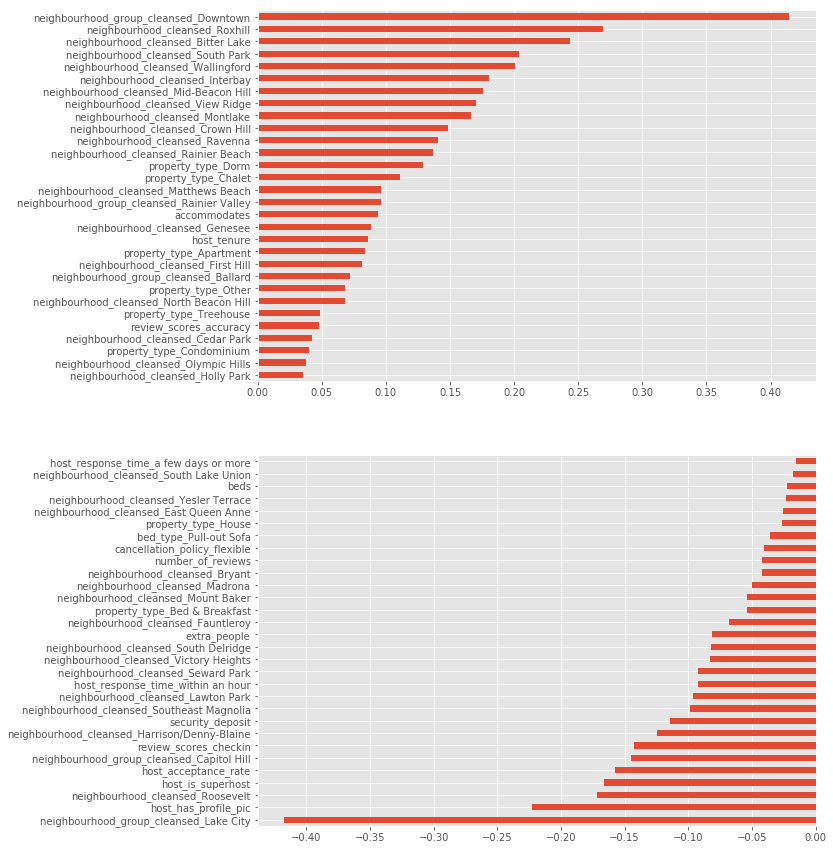

In [104]:
plt.figure(figsize=(10,15))
plt.subplot(2,1,2)
pd.Series(pipeline2.named_steps['model'].coef_, index= x_train.columns).sort_values()[:30].plot.barh()

plt.subplot(2,1,1)
pd.Series(pipeline2.named_steps['model'].coef_, index= x_train.columns).sort_values()[-30:].plot.barh()


#####  Interpretaion:

Neighborhood still plays a big role in the price. The downtown area is most positively correlated to the price- listing in downtown can be 50% (exp(0.45)-1 = 0.5) more expensive than non-downtown area holding everything else constant. On the contrary, the Lake City area is most negatively correlated to the price. If a listing is in Lake City area, the price will be 36% ((exp(-0.45)-1)*100%) lower than non-Lake City area.

The more security deposit the lower the prices.

### 3. Random Forest using log(price) as dependent variable

In [50]:
# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

pipeline4=Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'median')),
    ('model', RandomForestRegressor(n_estimators=200, oob_score= True))
    ]
)

params = {'model__max_depth': [15, 20], 'model__min_samples_leaf': [0.001, 0.005]}
cv = GridSearchCV(pipeline4, params, cv=10)

cv.fit(x_train, np.log(y_train))

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='median',
                                                      verbose=0)),
                                       ('model',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                           

In [60]:
print('r2 for training set using random forest is {}'.format(cv.score(x_train, np.log(y_train))))
best_model = cv.best_estimator_
y_pred_rf = best_model.predict(x_test)
print('r2 for test set using random forest is {}'.format(cv.score(x_test, np.log(y_test))))

r2 for training set using random forest is 0.8736972872524192
r2 for test set using random forest is 0.7185778508183365


In [96]:
# test how close the predicted prices are against true price
rand_id_1 = np.random.choice(y_test.index, 1)[0]
print('real price of listing id {} is {}, the predicted price is {}'.format(listing_clean.loc[rand_id_1].id, y_test.loc[rand_id_1], np.exp(y_pred_rf[np.argwhere(y_test.index== rand_id_1)[0][0]] )))

rand_id_2 = np.random.choice(y_test.index, 1)[0]
print('real price of listing id {} is {}, the predicted price is {}'.format(listing_clean.loc[rand_id_2].id, y_test.loc[rand_id_2], np.exp(y_pred_rf[np.argwhere(y_test.index== rand_id_2)[0][0]] )))

real price of listing id 6211882 is 60.0, the predicted price is 67.91639535714509
real price of listing id 8566242 is 200.0, the predicted price is 208.6164977598666


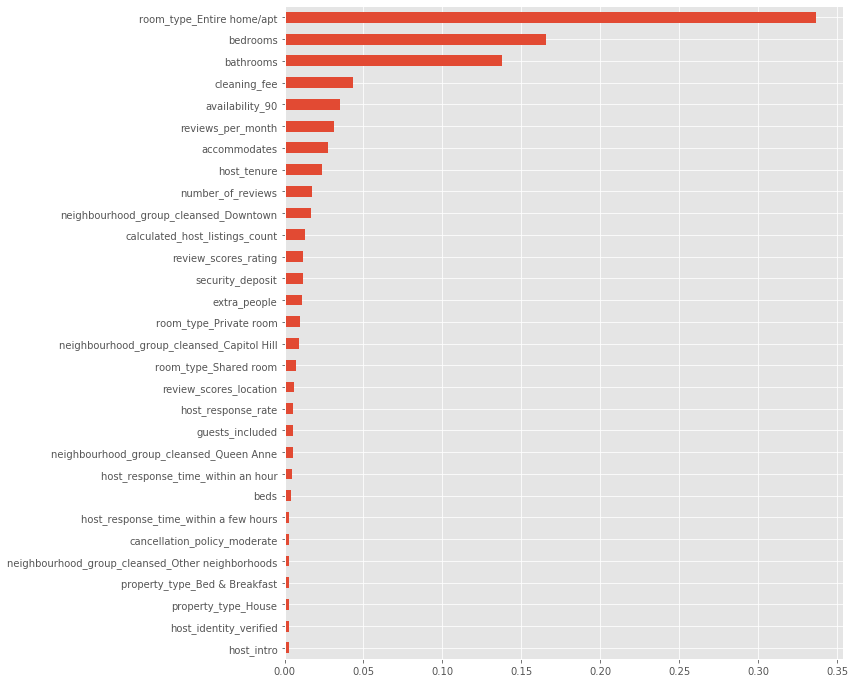

In [70]:
# feature importance
plt.figure(figsize=(10,12))
#plt.subplot(2,1,2)
pd.Series(cv.best_estimator_.named_steps['model'].feature_importances_, index= x_train.columns).sort_values()[-30:].plot.barh()


##### Interpretation
Quite different from the coefficients result from Lasso regression, Random Forest model ranks the property type as the top feature that affects the price the most, followed by number of bedrooms.

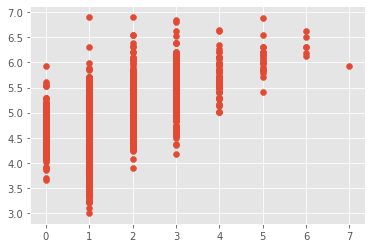

In [71]:
plt.scatter(listing_clean_dummy.bedrooms, np.log(listing_clean_dummy.price))

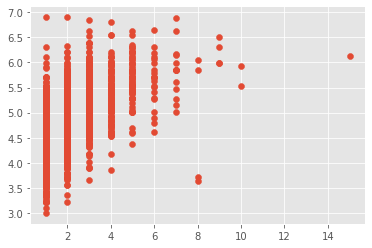

In [74]:
plt.scatter(listing_clean_dummy.beds, np.log(listing_clean_dummy.price))

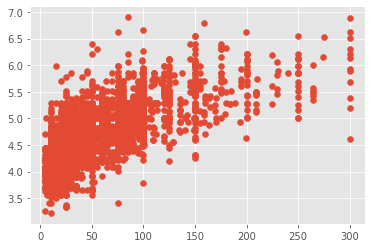

In [73]:
plt.scatter(listing_clean_dummy.cleaning_fee, np.log(listing_clean_dummy.price))

* Number of bedrooms, beds and cleaning fee are positively correlated to price.

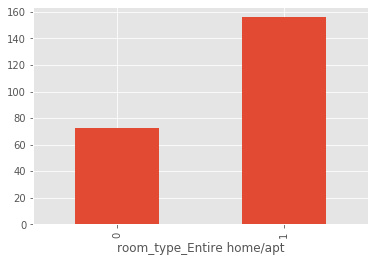

In [48]:
listing_clean_dummy.groupby('room_type_Entire home/apt').price.mean().plot.bar()

Text(0.5, 1.0, 'entire apt vs. other room type price')

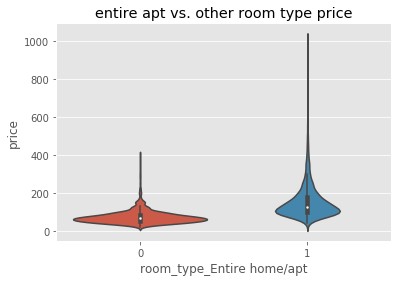

In [42]:
sns.violinplot(x="room_type_Entire home/apt", y="price", data=listing_clean_dummy)
plt.title('entire apt vs. other room type price')

* The average price for entire apt doubles that of other room types, and the listings of entire apt have a long tail of very high prices

## 4. Superhost Top Factors

In [115]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(listing_clean_dummy.drop('host_is_superhost',axis=1), listing_clean_dummy['host_is_superhost'], test_size=0.2)

In [116]:
y_train2.value_counts()

0    2434
1     620
Name: host_is_superhost, dtype: int64

In [117]:
# random forest
from sklearn.ensemble import RandomForestClassifier

pipeline4=Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'median')),
    ('model', RandomForestClassifier(n_estimators=100, oob_score= True))
    ]
)

pipeline4.fit(x_train2, y_train2)

Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity...tors=100, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False))])

In [120]:
from sklearn.metrics import roc_auc_score, f1_score, classification_report
print('roc score for training set using random forest is {}'.format(roc_auc_score(y_train2, pipeline4.predict(x_train2))))
y_pred_rf2 = pipeline4.predict(x_test2)
print('roc score for test set using random forest is {}'.format(roc_auc_score(y_test2, pipeline4.predict(x_test2))))
print('classfication report')
print(classification_report(y_test2, y_pred_rf2))

roc score for training set using random forest is 1.0
roc score for test set using random forest is 0.740788319338263
classfication report
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       606
           1       0.84      0.51      0.63       158

   micro avg       0.88      0.88      0.88       764
   macro avg       0.86      0.74      0.78       764
weighted avg       0.87      0.88      0.87       764



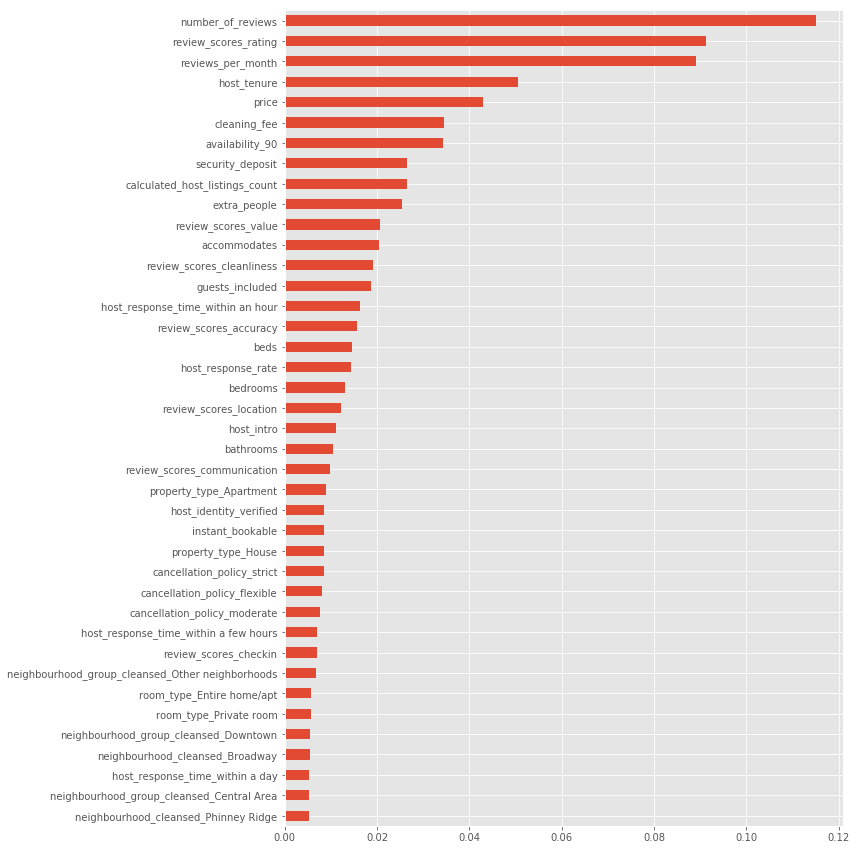

In [121]:
# feature importance
plt.figure(figsize=(10,15))
#plt.subplot(2,1,2)
pd.Series(pipeline4.named_steps['model'].feature_importances_, index= x_train2.columns).sort_values()[-40:].plot.barh()

Text(0.5, 1.0, 'superhosts vs. regular hosts average number of reviews')

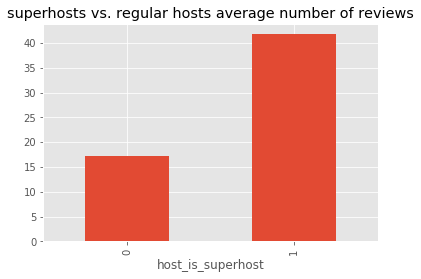

In [123]:
(listing_clean_dummy.groupby('host_is_superhost').number_of_reviews.mean()).plot.bar()
plt.title('superhosts vs. regular hosts average number of reviews')

Text(0.5, 1.0, 'superhosts vs. regular hosts average reviews_per_month')

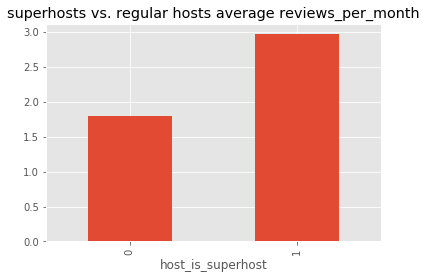

In [126]:
(listing_clean_dummy.groupby('host_is_superhost').reviews_per_month.mean()).plot.bar()
plt.title('superhosts vs. regular hosts average reviews_per_month')

Text(0.5, 1.0, 'superhosts vs. regular hosts number_of_reviews')

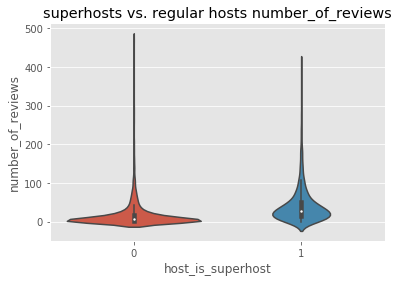

In [137]:
sns.violinplot(x="host_is_superhost", y="number_of_reviews", data=listing_clean_dummy)
plt.title('superhosts vs. regular hosts number_of_reviews')

Text(0.5, 1.0, 'superhosts vs. regular hosts reviews_per_month')

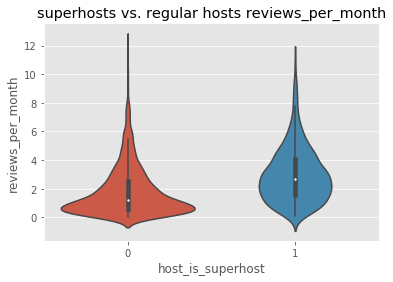

In [136]:
sns.violinplot(x="host_is_superhost", y="reviews_per_month", data=listing_clean_dummy)
plt.title('superhosts vs. regular hosts reviews_per_month')

Text(0.5, 1.0, 'superhosts vs. regular hosts tenure')

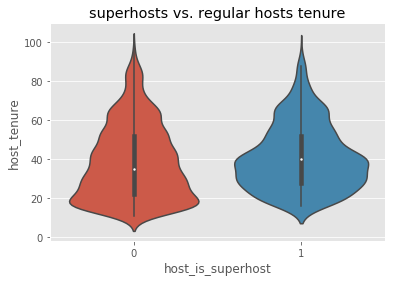

In [133]:
sns.violinplot(x="host_is_superhost", y="host_tenure", data=listing_clean_dummy)
plt.title('superhosts vs. regular hosts tenure')

superhosts have longer tenure compared to regular hosts which consists of a lot more new hosts

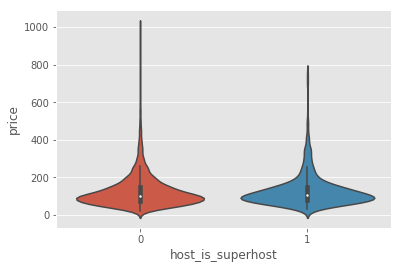

In [130]:
sns.violinplot(x="host_is_superhost", y="price", data=listing_clean_dummy)

superhosts price listings similar to regular hosts, except they don't have extremely expensive outlier listings.

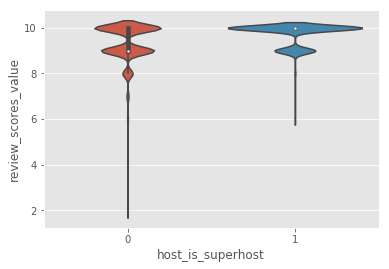

In [135]:
sns.violinplot(x="host_is_superhost", y="review_scores_value", data=listing_clean_dummy)

* superhosts get much higher review score in value

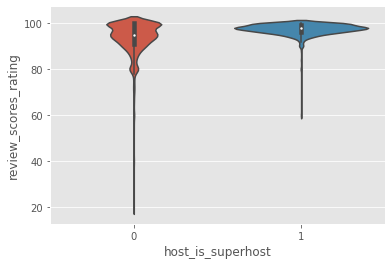

In [51]:
sns.violinplot(x="host_is_superhost", y="review_scores_rating", data=listing_clean_dummy)

* like we discovered in the EDA part, superhosts ratings are highly concentrated in the range of 90-100, making them reliable hosts who provide quality experience for the travellers. And this is the important factor to improve if a regular host wants to upgrade to a superhost. 